In [56]:
import numpy as np
import pandas as pd
from math import sqrt
from pandas import DataFrame
from pandas import read_csv
from pandas import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from itertools import cycle

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

<ipython-input-56-0534c83bc219>:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [57]:
data = pd.read_csv("btc_6h.csv")
data.head()

,datetime,open,high,low,close,volume
0,2018-01-01 05:30:00,13715.65,13715.65,13155.38,13558.99,2421.241182
1,2018-01-01 11:30:00,13539.00,13818.55,13001.13,13220.56,1876.934392
2,2018-01-01 17:30:00,13220.56,13330.00,12750.00,13022.00,2427.898747
3,2018-01-01 23:30:00,13007.87,13599.70,12940.00,13380.00,1883.841523
4,2018-01-02 05:30:00,13382.16,13850.00,12890.02,13166.95,3957.954564


In [58]:
data.shape

(5959, 6)

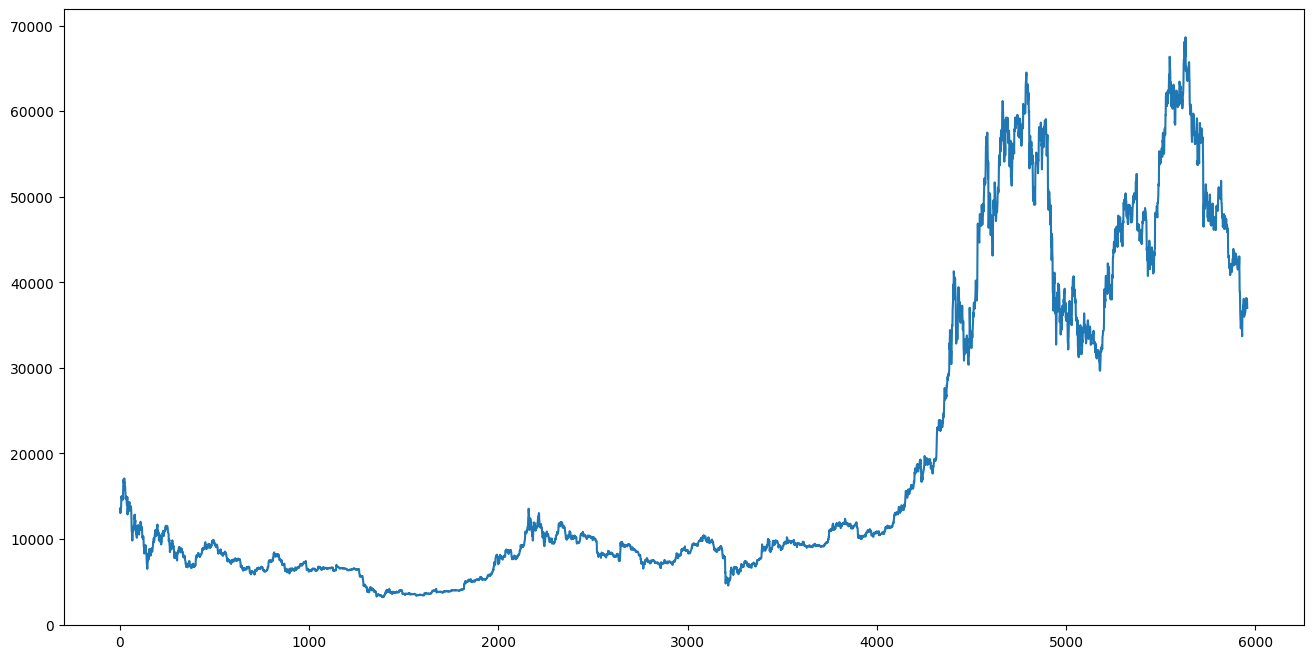

In [59]:
plt.figure(figsize=(16,8))
plt.plot(data['close'])
plt.show()

In [60]:
close_data = data['close']
close_data
close_df = pd.DataFrame(close_data,columns =['close'])
close_df.head()

,close
0,13558.99
1,13220.56
2,13022.00
3,13380.00
4,13166.95


In [61]:
data['next'] = data['close'].shift(-1)

In [62]:
data.head()

,datetime,open,high,low,close,volume,next
0,2018-01-01 05:30:00,13715.65,13715.65,13155.38,13558.99,2421.241182,13220.56
1,2018-01-01 11:30:00,13539.00,13818.55,13001.13,13220.56,1876.934392,13022.00
2,2018-01-01 17:30:00,13220.56,13330.00,12750.00,13022.00,2427.898747,13380.00
3,2018-01-01 23:30:00,13007.87,13599.70,12940.00,13380.00,1883.841523,13166.95
4,2018-01-02 05:30:00,13382.16,13850.00,12890.02,13166.95,3957.954564,13490.00


In [63]:
data.dtypes

datetime     object
open        float64
high        float64
low         float64
close       float64
volume      float64
next        float64
dtype: object

Checking Autocorrelation for Time Series Analysis

In [66]:
# Split into train and test sets
X = data['next'].values
size = int(len(X) * 0.8)

# Split first 80% for training
X_train_3 = X[:size]

# Split next 10% (80-90%) for validation
validation_size = int(size + 0.1 * len(X))
X_val_3 = X[size:validation_size]

# Split last 10% (90-100%) for testing
X_test_3 = X[validation_size:]

# Initialize a list to store prediction history
history = [x for x in X_train_3]

In [67]:
# Walk-forward validation using ARIMA model for validation data

val_pred = list()
for t in range(len(X_val_3)):
    # Fit ARIMA model on the training data
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()

    # Forecast the next value
    output = model_fit.forecast()
    yhat = output[0]

    # Append the predicted value to the list of predictions
    val_pred.append(yhat)

    # Update the history with the observed value
    obs = X_val_3[t]
    history.append(obs)

    # Print the predicted and expected values for each iteration
    print('Predicted=%f, Expected=%f' % (yhat, obs))

Predicted=56449.352711, Expected=57749.090000
Predicted=57790.745149, Expected=58077.520000
Predicted=58039.688244, Expected=57947.670000
Predicted=57975.702948, Expected=58527.190000
Predicted=58477.811413, Expected=58405.080000
Predicted=58369.520184, Expected=58142.540000
Predicted=58147.735753, Expected=60851.920000
Predicted=60865.864873, Expected=60575.940000
Predicted=60582.521684, Expected=60100.480000
Predicted=60154.732337, Expected=59769.130000
Predicted=59615.336320, Expected=59679.970000
Predicted=59649.409020, Expected=59721.840000
Predicted=59745.818620, Expected=59864.390000
Predicted=59889.257077, Expected=60002.430000
Predicted=60014.944585, Expected=60207.010000
Predicted=60212.119147, Expected=60241.500000
Predicted=60236.902664, Expected=59749.400000
Predicted=59735.284896, Expected=59860.000000
Predicted=59847.693290, Expected=60668.740000
Predicted=60670.487553, Expected=62942.210000
Predicted=63017.221342, Expected=63332.850000
Predicted=63361.224265, Expected=6

In [68]:
# Convert validation and predictions to DataFrames for plotting
val_df = DataFrame(X_val_3, index=data['next'].index[size:validation_size], columns=['Actual'])
val_pred_df = DataFrame(val_pred, index=data['next'].index[size:validation_size], columns=['Predicted'])

# Evaluate forecasts for validation data
mse_val = mean_squared_error(val_df, val_pred_df)
rmse_val = np.sqrt(mse_val)

# Calculate R-squared (R^2) score for validation data
r2_val = r2_score(val_df, val_pred_df)

# Calculate Mean Absolute Error (MAE) for validation data
mae_val = mean_absolute_error(val_df, val_pred_df)

# Calculate Mean Absolute Percentage Error (MAPE) for validation data
mape_val = np.mean(np.abs((np.array(val_df) - np.array(val_pred_df)) / np.array(val_df))) * 100

# Print results for validation data
print(f'Mean Squared Error (MSE) for Validation Data: {mse_val:.3f}')
print(f'Root Mean Squared Error (RMSE) for Validation Data: {rmse_val:.3f}')
print(f'R-squared (R^2) Score for Validation Data: {r2_val:.3f}')
print(f'Mean Absolute Error (MAE) for Validation Data: {mae_val:.3f}')
print(f'Mean Absolute Percentage Error (MAPE) for Validation Data: {mape_val:.3f}%')

Mean Squared Error (MSE) for Validation Data: 932577.839
Root Mean Squared Error (RMSE) for Validation Data: 965.701
R-squared (R^2) Score for Validation Data: 0.989
Mean Absolute Error (MAE) for Validation Data: 693.863
Mean Absolute Percentage Error (MAPE) for Validation Data: 1.642%


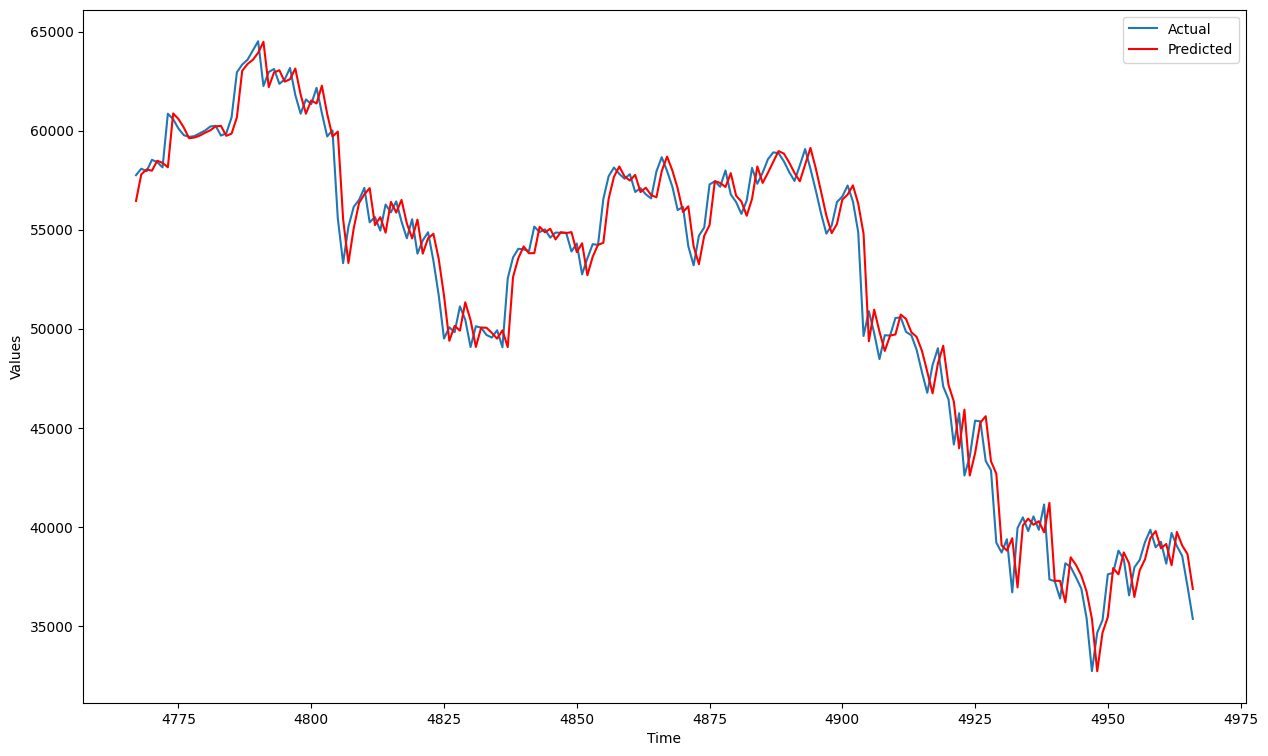

In [69]:
# Set the range you want to zoom in on
start_index = 0
end_index = 200

# Extract data for the specified range
actual_values = val_df['Actual'].iloc[start_index:end_index]
predicted_values = val_pred_df['Predicted'].iloc[start_index:end_index]
time_index = val_df.index[start_index:end_index]

# Set the plot size
plt.figure(figsize=(15, 9))

# Plot actual values
plt.plot(time_index, actual_values, label='Actual')

# Plot predicted values in red
plt.plot(time_index, predicted_values, color='red', label='Predicted')

# Add labels to the axes
plt.xlabel('Time')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [70]:
test_pred = list()
for t in range(len(X_test_3)):
    # Fit ARIMA model on the training data
    model = ARIMA(history, order=(5, 1, 0))
    model_fit = model.fit()

    # Forecast the next value
    output = model_fit.forecast()
    yhat = output[0]

    # Append the predicted value to the list of predictions
    test_pred.append(yhat)

    # Update the history with the observed value
    obs = X_test_3[t]
    history.append(obs)

    # Print the predicted and expected values for each iteration
    print('Predicted=%f, Expected=%f' % (yhat, obs))

Predicted=50218.486700, Expected=49902.940000
Predicted=49895.272380, Expected=49954.830000
Predicted=49967.925273, Expected=49915.640000
Predicted=49908.857240, Expected=49688.800000
Predicted=49712.322045, Expected=50198.780000
Predicted=50192.276097, Expected=50299.690000
Predicted=50313.714785, Expected=51756.880000
Predicted=51753.309211, Expected=51759.990000
Predicted=51748.482311, Expected=51400.670000
Predicted=51361.442140, Expected=51672.980000
Predicted=51562.700552, Expected=52663.900000
Predicted=52653.924334, Expected=52665.010000
Predicted=52699.426042, Expected=50941.480000
Predicted=50918.689516, Expected=46606.440000
Predicted=46515.777212, Expected=46863.730000
Predicted=46838.041004, Expected=46074.840000
Predicted=46298.972919, Expected=46394.090000
Predicted=46685.705054, Expected=46200.190000
Predicted=46240.944935, Expected=46048.310000
Predicted=46088.807306, Expected=46304.440000
Predicted=46290.000418, Expected=46293.150000
Predicted=46311.733075, Expected=4

In [77]:
# Convert test and predictions to DataFrames for plotting
test_df = DataFrame(X_test_3, index=data['next'].index[validation_size:], columns=['Actual'])
test_pred_df = DataFrame(test_pred, index=data['next'].index[validation_size:], columns=['Predicted'])

In [82]:
test_df.drop(test_df.tail(1).index, inplace=True)

In [86]:
test_pred_df.drop(test_pred_df.tail(1).index, inplace=True)

In [87]:
# Evaluate forecasts for test data
mse_test = mean_squared_error(test_df, test_pred_df)
rmse_test = np.sqrt(mse_test)

# Calculate R-squared (R^2) score for test data
r2_test = r2_score(test_df, test_pred_df)

# Calculate Mean Absolute Error (MAE) for test data
mae_test = mean_absolute_error(test_df, test_pred_df)

# Calculate Mean Absolute Percentage Error (MAPE) for test data
mape_test = np.mean(np.abs((np.array(test_df) - np.array(test_pred_df)) / np.array(test_df))) * 100

# Print results for test data
print(f'Mean Squared Error (MSE) for Test Data: {mse_test:.3f}')
print(f'Root Mean Squared Error (RMSE) for Test Data: {rmse_test:.3f}')
print(f'R-squared (R^2) Score for Test Data: {r2_test:.3f}')
print(f'Mean Absolute Error (MAE) for Test Data: {mae_test:.3f}')
print(f'Mean Absolute Percentage Error (MAPE) for Test Data: {mape_test:.3f}%')

Mean Squared Error (MSE) for Test Data: 772822.537
Root Mean Squared Error (RMSE) for Test Data: 879.103
R-squared (R^2) Score for Test Data: 0.988
Mean Absolute Error (MAE) for Test Data: 598.761
Mean Absolute Percentage Error (MAPE) for Test Data: 1.191%


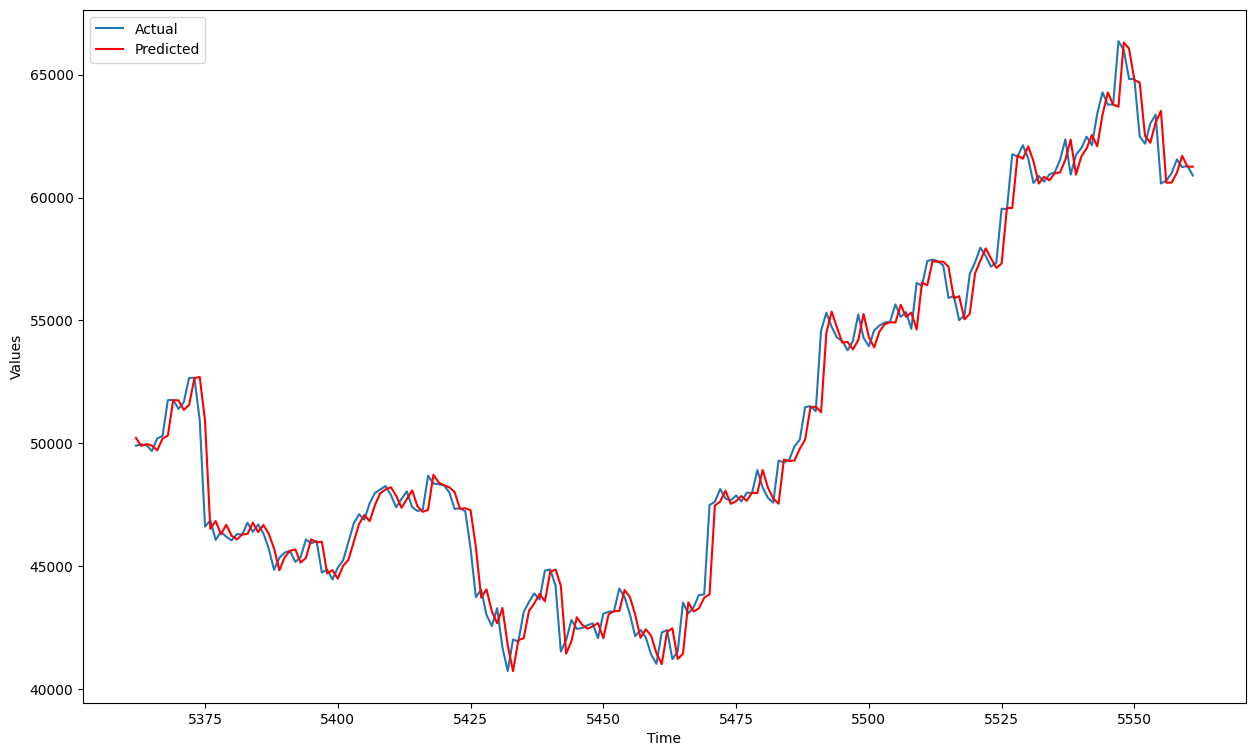

In [88]:
# Set the range you want to zoom in on
start_index = 0
end_index = 200

# Extract data for the specified range
actual_values_test = test_df['Actual'].iloc[start_index:end_index]
predicted_values_test = test_pred_df['Predicted'].iloc[start_index:end_index]
time_index_test = test_df.index[start_index:end_index]

# Set the plot size
plt.figure(figsize=(15, 9))

# Plot actual values
plt.plot(time_index_test, actual_values_test, label='Actual')

# Plot predicted values in red
plt.plot(time_index_test, predicted_values_test, color='red', label='Predicted')

# Add labels to the axes
plt.xlabel('Time')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show the plot
plt.show()